In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import optimizers

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

Adam = optimizers.Adam(lr=0.001)

In [2]:
csv_path_train = 'testset/J0003_0024_0221_20110307012732_cell_19.csv'
csv_path_test = 'testset/J0003_0024_0221_20110307012732_cell_03.csv'
df = pd.read_csv(csv_path_train)
df_test = pd.read_csv(csv_path_test)

date_time = pd.to_datetime(df.pop('MeasuredDate'), format='%Y.%m.%d %H:%M')
date_time_test = pd.to_datetime(df_test.pop('MeasuredDate'), format='%Y.%m.%d %H:%M')

In [3]:
df.head()

,CellNo,Resistance,Volt,Temp
0,19,0.243,2.23,-20
1,19,0.242,2.23,-20
2,19,0.244,2.23,-20
3,19,0.243,2.23,-20
4,19,0.243,2.23,-20


In [4]:
df_test.head()

,CellNo,Resistance,Volt,Temp
0,3,0.298,2.23,-20
1,3,0.298,2.23,-20
2,3,0.297,2.24,-20
3,3,0.299,2.23,-20
4,3,0.298,2.24,-20


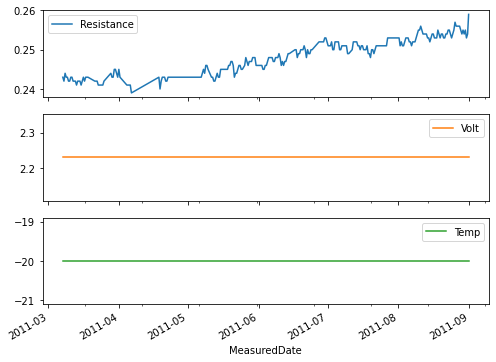

In [5]:
plot_cols = ['Resistance', 'Volt', 'Temp']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)


array([<AxesSubplot:xlabel='MeasuredDate'>,
       <AxesSubplot:xlabel='MeasuredDate'>,
       <AxesSubplot:xlabel='MeasuredDate'>], dtype=object)

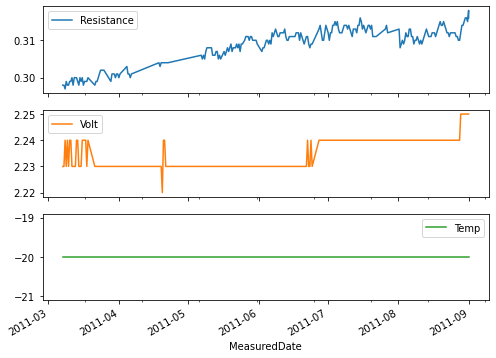

In [6]:
#plot_cols = ['Resistance', 'Volt', 'Temp']
plot_features_test = df_test[plot_cols]
plot_features_test.index = date_time_test
plot_features_test.plot(subplots=True)

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CellNo,252.0,19.000000,0.000000,19.000,19.000,19.000,19.000,19.000
Resistance,252.0,0.248282,0.004474,0.239,0.244,0.249,0.252,0.259
Volt,252.0,2.230000,0.000000,2.230,2.230,2.230,2.230,2.230
Temp,252.0,-20.000000,0.000000,-20.000,-20.000,-20.000,-20.000,-20.000


In [8]:
column_indices = {name: i for i, name in enumerate(df.columns)}
column_indices = {name: i for i, name in enumerate(df_test.columns)}

In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()
df = scaler.fit_transform(df[plot_cols])
df_test = scaler.fit_transform(df_test[plot_cols])
df = pd.DataFrame(df)
df_test = pd.DataFrame(df_test)
df.columns = plot_cols
df_test.columns = plot_cols

In [10]:
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.8)]
test_df = df[int(n*0.8):]
#n_test = len(df_test)
test_df_test = df_test[:int(n*0.7)]
label_df = df_test[int(n*0.7):]

num_features = df.shape[1]
#print(int(n*0.8),int(n*0.2),len(test_df), len(label_df))

In [11]:
df.head()

,Resistance,Volt,Temp
0,0.20,0.0,0.0
1,0.15,0.0,0.0
2,0.25,0.0,0.0
3,0.20,0.0,0.0
4,0.20,0.0,0.0


<AxesSubplot:>

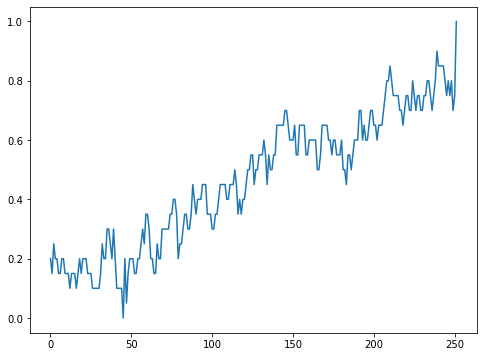

In [12]:
df['Resistance'].plot()

In [13]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

    # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [14]:
#w1 = WindowGenerator(input_width = 28, label_width=28, shift=1, label_columns = ['Resistance'])
#w1

In [15]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [16]:
def plot(self, model=None, plot_col='Resistance', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    max_n=1
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.plot(self.label_indices, labels[n, :, label_col_index], label='Labels', c='#2ca02c', zorder=-10)
                #edgecolors='k', c='#2ca02c', s=1)
        if model is not None:
            predictions = model(inputs)
            plt.plot(self.label_indices, predictions[n, :, label_col_index], label='Predictions', c='#ff7f0e', zorder=-10)
                   
             #           edgecolors='k', label='Predictions',
              #    c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [17]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets = None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)
    
    ds = ds.map(self.split_window)
    
    return ds

WindowGenerator.make_dataset = make_dataset

In [18]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

def test_test(self):
    return self.make_dataset(self.test_df_test)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
    # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
    # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example
WindowGenerator.test_test = test_test

Total window size: 174
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149]
Label indices: [150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173]
Label column name(s): None

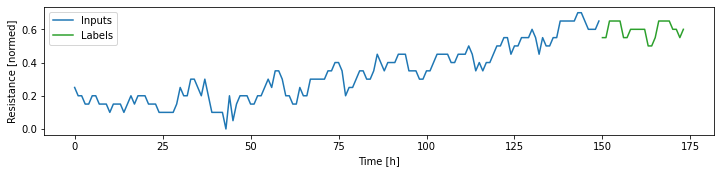

In [19]:
OUT_STEPS = 24

multi_window = WindowGenerator(input_width=150,
                              label_width=OUT_STEPS,
                              shift=OUT_STEPS)

multi_window.plot()
multi_window

In [20]:
MAX_EPOCHS = 1500

def compile_and_fit(model, window, patience=500):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=patience,
                                                        mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                    # optimizer=tf.optimizers.Adam(),
                    optimizer=Adam,
                    metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

In [21]:
model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # tf.keras.layers.LSTM(32, activation='relu', kernel_initializer='he_normal', dropout=0.1, return_sequences=False),
    # tf.keras.layers.Dropout(rate=0.2),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [22]:
history = compile_and_fit(model, multi_window)

Epoch 1/1500
1/1 [==============================] - 4s 4s/step - loss: 0.1199 - mean_absolute_error: 0.1993
Epoch 2/1500
1/1 [==============================] - 0s 108ms/step - loss: 0.1185 - mean_absolute_error: 0.1981
Epoch 3/1500
1/1 [==============================] - 0s 107ms/step - loss: 0.1169 - mean_absolute_error: 0.1967
Epoch 4/1500
1/1 [==============================] - 0s 110ms/step - loss: 0.1152 - mean_absolute_error: 0.1953
Epoch 5/1500
1/1 [==============================] - 0s 112ms/step - loss: 0.1134 - mean_absolute_error: 0.1937
Epoch 6/1500
1/1 [==============================] - 0s 109ms/step - loss: 0.1114 - mean_absolute_error: 0.1920
Epoch 7/1500
1/1 [==============================] - 0s 98ms/step - loss: 0.1093 - mean_absolute_error: 0.1902
Epoch 8/1500
1/1 [==============================] - 0s 106ms/step - loss: 0.1069 - mean_absolute_error: 0.1881
Epoch 9/1500
1/1 [==============================] - 0s 121ms/step - loss: 0.1044 - mean_absolute_error: 0.1858
Epoch

Epoch 34/1500
1/1 [==============================] - 0s 96ms/step - loss: 0.0028 - mean_absolute_error: 0.0274
Epoch 35/1500
1/1 [==============================] - 0s 94ms/step - loss: 0.0035 - mean_absolute_error: 0.0317
Epoch 36/1500
1/1 [==============================] - 0s 99ms/step - loss: 0.0041 - mean_absolute_error: 0.0347
Epoch 37/1500
1/1 [==============================] - 0s 102ms/step - loss: 0.0044 - mean_absolute_error: 0.0364
Epoch 38/1500
1/1 [==============================] - 0s 107ms/step - loss: 0.0045 - mean_absolute_error: 0.0369
Epoch 39/1500
1/1 [==============================] - 0s 108ms/step - loss: 0.0043 - mean_absolute_error: 0.0363
Epoch 40/1500
1/1 [==============================] - 0s 101ms/step - loss: 0.0040 - mean_absolute_error: 0.0348
Epoch 41/1500
1/1 [==============================] - 0s 100ms/step - loss: 0.0036 - mean_absolute_error: 0.0326
Epoch 42/1500
1/1 [==============================] - 0s 102ms/step - loss: 0.0030 - mean_absolute_error: 0.

1/1 [==============================] - 0s 106ms/step - loss: 5.0508e-04 - mean_absolute_error: 0.0106
Epoch 67/1500
1/1 [==============================] - 0s 147ms/step - loss: 4.5917e-04 - mean_absolute_error: 0.0101
Epoch 68/1500
1/1 [==============================] - 0s 106ms/step - loss: 4.2415e-04 - mean_absolute_error: 0.0098
Epoch 69/1500
1/1 [==============================] - 0s 146ms/step - loss: 4.0054e-04 - mean_absolute_error: 0.0095
Epoch 70/1500
1/1 [==============================] - 0s 117ms/step - loss: 3.8782e-04 - mean_absolute_error: 0.0091
Epoch 71/1500
1/1 [==============================] - 0s 106ms/step - loss: 3.8455e-04 - mean_absolute_error: 0.0088
Epoch 72/1500
1/1 [==============================] - 0s 115ms/step - loss: 3.8870e-04 - mean_absolute_error: 0.0087
Epoch 73/1500
1/1 [==============================] - 0s 103ms/step - loss: 3.9785e-04 - mean_absolute_error: 0.0088
Epoch 74/1500
1/1 [==============================] - 0s 125ms/step - loss: 4.0955e-04 

1/1 [==============================] - 0s 99ms/step - loss: 3.8785e-04 - mean_absolute_error: 0.0087
Epoch 99/1500
1/1 [==============================] - 0s 106ms/step - loss: 3.8699e-04 - mean_absolute_error: 0.0087
Epoch 100/1500
1/1 [==============================] - 0s 113ms/step - loss: 3.8574e-04 - mean_absolute_error: 0.0087
Epoch 101/1500
1/1 [==============================] - 0s 105ms/step - loss: 3.8427e-04 - mean_absolute_error: 0.0086
Epoch 102/1500
1/1 [==============================] - 0s 101ms/step - loss: 3.8274e-04 - mean_absolute_error: 0.0086
Epoch 103/1500
1/1 [==============================] - 0s 112ms/step - loss: 3.8130e-04 - mean_absolute_error: 0.0085
Epoch 104/1500
1/1 [==============================] - 0s 104ms/step - loss: 3.8009e-04 - mean_absolute_error: 0.0085
Epoch 105/1500
1/1 [==============================] - 0s 109ms/step - loss: 3.7916e-04 - mean_absolute_error: 0.0085
Epoch 106/1500
1/1 [==============================] - 0s 110ms/step - loss: 3.785

1/1 [==============================] - 0s 101ms/step - loss: 3.7843e-04 - mean_absolute_error: 0.0084
Epoch 131/1500
1/1 [==============================] - 0s 97ms/step - loss: 3.7845e-04 - mean_absolute_error: 0.0084
Epoch 132/1500
1/1 [==============================] - 0s 98ms/step - loss: 3.7845e-04 - mean_absolute_error: 0.0084
Epoch 133/1500
1/1 [==============================] - 0s 98ms/step - loss: 3.7843e-04 - mean_absolute_error: 0.0084
Epoch 134/1500
1/1 [==============================] - 0s 98ms/step - loss: 3.7840e-04 - mean_absolute_error: 0.0084
Epoch 135/1500
1/1 [==============================] - 0s 95ms/step - loss: 3.7835e-04 - mean_absolute_error: 0.0084
Epoch 136/1500
1/1 [==============================] - 0s 92ms/step - loss: 3.7830e-04 - mean_absolute_error: 0.0084
Epoch 137/1500
1/1 [==============================] - 0s 95ms/step - loss: 3.7826e-04 - mean_absolute_error: 0.0084
Epoch 138/1500
1/1 [==============================] - 0s 96ms/step - loss: 3.7822e-04 

1/1 [==============================] - 0s 101ms/step - loss: 3.7817e-04 - mean_absolute_error: 0.0084
Epoch 163/1500
1/1 [==============================] - 0s 99ms/step - loss: 3.7817e-04 - mean_absolute_error: 0.0084
Epoch 164/1500
1/1 [==============================] - 0s 97ms/step - loss: 3.7817e-04 - mean_absolute_error: 0.0084
Epoch 165/1500
1/1 [==============================] - 0s 97ms/step - loss: 3.7817e-04 - mean_absolute_error: 0.0083
Epoch 166/1500
1/1 [==============================] - 0s 100ms/step - loss: 3.7817e-04 - mean_absolute_error: 0.0083
Epoch 167/1500
1/1 [==============================] - 0s 97ms/step - loss: 3.7817e-04 - mean_absolute_error: 0.0083
Epoch 168/1500
1/1 [==============================] - 0s 115ms/step - loss: 3.7817e-04 - mean_absolute_error: 0.0083
Epoch 169/1500
1/1 [==============================] - 0s 97ms/step - loss: 3.7816e-04 - mean_absolute_error: 0.0083
Epoch 170/1500
1/1 [==============================] - 0s 110ms/step - loss: 3.7816e-

1/1 [==============================] - 0s 95ms/step - loss: 3.7816e-04 - mean_absolute_error: 0.0083
Epoch 195/1500
1/1 [==============================] - 0s 93ms/step - loss: 3.7816e-04 - mean_absolute_error: 0.0083
Epoch 196/1500
1/1 [==============================] - 0s 100ms/step - loss: 3.7816e-04 - mean_absolute_error: 0.0083
Epoch 197/1500
1/1 [==============================] - 0s 92ms/step - loss: 3.7816e-04 - mean_absolute_error: 0.0083
Epoch 198/1500
1/1 [==============================] - 0s 93ms/step - loss: 3.7816e-04 - mean_absolute_error: 0.0083
Epoch 199/1500
1/1 [==============================] - 0s 94ms/step - loss: 3.7815e-04 - mean_absolute_error: 0.0083
Epoch 200/1500
1/1 [==============================] - 0s 93ms/step - loss: 3.7815e-04 - mean_absolute_error: 0.0083
Epoch 201/1500
1/1 [==============================] - 0s 94ms/step - loss: 3.7815e-04 - mean_absolute_error: 0.0083
Epoch 202/1500
1/1 [==============================] - 0s 102ms/step - loss: 3.7815e-04

1/1 [==============================] - 0s 93ms/step - loss: 3.7815e-04 - mean_absolute_error: 0.0083
Epoch 227/1500
1/1 [==============================] - 0s 92ms/step - loss: 3.7815e-04 - mean_absolute_error: 0.0083
Epoch 228/1500
1/1 [==============================] - 0s 97ms/step - loss: 3.7815e-04 - mean_absolute_error: 0.0083
Epoch 229/1500
1/1 [==============================] - 0s 97ms/step - loss: 3.7815e-04 - mean_absolute_error: 0.0083
Epoch 230/1500
1/1 [==============================] - 0s 100ms/step - loss: 3.7815e-04 - mean_absolute_error: 0.0083
Epoch 231/1500
1/1 [==============================] - 0s 93ms/step - loss: 3.7815e-04 - mean_absolute_error: 0.0083
Epoch 232/1500
1/1 [==============================] - 0s 97ms/step - loss: 3.7815e-04 - mean_absolute_error: 0.0083
Epoch 233/1500
1/1 [==============================] - 0s 97ms/step - loss: 3.7815e-04 - mean_absolute_error: 0.0083
Epoch 234/1500
1/1 [==============================] - 0s 101ms/step - loss: 3.7815e-04

1/1 [==============================] - 0s 99ms/step - loss: 3.7814e-04 - mean_absolute_error: 0.0083
Epoch 259/1500
1/1 [==============================] - 0s 96ms/step - loss: 3.7814e-04 - mean_absolute_error: 0.0083
Epoch 260/1500
1/1 [==============================] - 0s 97ms/step - loss: 3.7814e-04 - mean_absolute_error: 0.0083
Epoch 261/1500
1/1 [==============================] - 0s 98ms/step - loss: 3.7814e-04 - mean_absolute_error: 0.0083
Epoch 262/1500
1/1 [==============================] - 0s 105ms/step - loss: 3.7814e-04 - mean_absolute_error: 0.0083
Epoch 263/1500
1/1 [==============================] - 0s 98ms/step - loss: 3.7814e-04 - mean_absolute_error: 0.0083
Epoch 264/1500
1/1 [==============================] - 0s 109ms/step - loss: 3.7814e-04 - mean_absolute_error: 0.0083
Epoch 265/1500
1/1 [==============================] - 0s 103ms/step - loss: 3.7814e-04 - mean_absolute_error: 0.0083
Epoch 266/1500
1/1 [==============================] - 0s 102ms/step - loss: 3.7814e-

1/1 [==============================] - 0s 102ms/step - loss: 3.7813e-04 - mean_absolute_error: 0.0083
Epoch 291/1500
1/1 [==============================] - 0s 108ms/step - loss: 3.7813e-04 - mean_absolute_error: 0.0083
Epoch 292/1500
1/1 [==============================] - 0s 98ms/step - loss: 3.7813e-04 - mean_absolute_error: 0.0083
Epoch 293/1500
1/1 [==============================] - 0s 101ms/step - loss: 3.7813e-04 - mean_absolute_error: 0.0083
Epoch 294/1500
1/1 [==============================] - 0s 100ms/step - loss: 3.7813e-04 - mean_absolute_error: 0.0083
Epoch 295/1500
1/1 [==============================] - 0s 133ms/step - loss: 3.7813e-04 - mean_absolute_error: 0.0083
Epoch 296/1500
1/1 [==============================] - 0s 100ms/step - loss: 3.7813e-04 - mean_absolute_error: 0.0083
Epoch 297/1500
1/1 [==============================] - 0s 99ms/step - loss: 3.7813e-04 - mean_absolute_error: 0.0083
Epoch 298/1500
1/1 [==============================] - 0s 132ms/step - loss: 3.781

1/1 [==============================] - 0s 112ms/step - loss: 3.7812e-04 - mean_absolute_error: 0.0083
Epoch 323/1500
1/1 [==============================] - 0s 104ms/step - loss: 3.7812e-04 - mean_absolute_error: 0.0083
Epoch 324/1500
1/1 [==============================] - 0s 102ms/step - loss: 3.7812e-04 - mean_absolute_error: 0.0083
Epoch 325/1500
1/1 [==============================] - 0s 104ms/step - loss: 3.7812e-04 - mean_absolute_error: 0.0083
Epoch 326/1500
1/1 [==============================] - 0s 106ms/step - loss: 3.7812e-04 - mean_absolute_error: 0.0083
Epoch 327/1500
1/1 [==============================] - 0s 95ms/step - loss: 3.7812e-04 - mean_absolute_error: 0.0083
Epoch 328/1500
1/1 [==============================] - 0s 100ms/step - loss: 3.7812e-04 - mean_absolute_error: 0.0083
Epoch 329/1500
1/1 [==============================] - 0s 104ms/step - loss: 3.7812e-04 - mean_absolute_error: 0.0083
Epoch 330/1500
1/1 [==============================] - 0s 99ms/step - loss: 3.781

1/1 [==============================] - 0s 102ms/step - loss: 3.7811e-04 - mean_absolute_error: 0.0083
Epoch 355/1500
1/1 [==============================] - 0s 107ms/step - loss: 3.7811e-04 - mean_absolute_error: 0.0083
Epoch 356/1500
1/1 [==============================] - 0s 97ms/step - loss: 3.7811e-04 - mean_absolute_error: 0.0083
Epoch 357/1500
1/1 [==============================] - 0s 100ms/step - loss: 3.7811e-04 - mean_absolute_error: 0.0083
Epoch 358/1500
1/1 [==============================] - 0s 104ms/step - loss: 3.7811e-04 - mean_absolute_error: 0.0083
Epoch 359/1500
1/1 [==============================] - 0s 102ms/step - loss: 3.7811e-04 - mean_absolute_error: 0.0083
Epoch 360/1500
1/1 [==============================] - 0s 114ms/step - loss: 3.7811e-04 - mean_absolute_error: 0.0083
Epoch 361/1500
1/1 [==============================] - 0s 108ms/step - loss: 3.7811e-04 - mean_absolute_error: 0.0083
Epoch 362/1500
1/1 [==============================] - 0s 114ms/step - loss: 3.78

1/1 [==============================] - 0s 97ms/step - loss: 3.7810e-04 - mean_absolute_error: 0.0083
Epoch 387/1500
1/1 [==============================] - 0s 97ms/step - loss: 3.7810e-04 - mean_absolute_error: 0.0083
Epoch 388/1500
1/1 [==============================] - 0s 99ms/step - loss: 3.7810e-04 - mean_absolute_error: 0.0083
Epoch 389/1500
1/1 [==============================] - 0s 106ms/step - loss: 3.7810e-04 - mean_absolute_error: 0.0083
Epoch 390/1500
1/1 [==============================] - 0s 98ms/step - loss: 3.7810e-04 - mean_absolute_error: 0.0083
Epoch 391/1500
1/1 [==============================] - 0s 99ms/step - loss: 3.7810e-04 - mean_absolute_error: 0.0083
Epoch 392/1500
1/1 [==============================] - 0s 103ms/step - loss: 3.7810e-04 - mean_absolute_error: 0.0083
Epoch 393/1500
1/1 [==============================] - 0s 103ms/step - loss: 3.7810e-04 - mean_absolute_error: 0.0083
Epoch 394/1500
1/1 [==============================] - 0s 99ms/step - loss: 3.7810e-0

1/1 [==============================] - 0s 106ms/step - loss: 3.7809e-04 - mean_absolute_error: 0.0083
Epoch 419/1500
1/1 [==============================] - 0s 120ms/step - loss: 3.7809e-04 - mean_absolute_error: 0.0083
Epoch 420/1500
1/1 [==============================] - 0s 116ms/step - loss: 3.7809e-04 - mean_absolute_error: 0.0083
Epoch 421/1500
1/1 [==============================] - 0s 122ms/step - loss: 3.7809e-04 - mean_absolute_error: 0.0083
Epoch 422/1500
1/1 [==============================] - 0s 101ms/step - loss: 3.7809e-04 - mean_absolute_error: 0.0083
Epoch 423/1500
1/1 [==============================] - 0s 123ms/step - loss: 3.7809e-04 - mean_absolute_error: 0.0083
Epoch 424/1500
1/1 [==============================] - 0s 109ms/step - loss: 3.7809e-04 - mean_absolute_error: 0.0083
Epoch 425/1500
1/1 [==============================] - 0s 109ms/step - loss: 3.7809e-04 - mean_absolute_error: 0.0083
Epoch 426/1500
1/1 [==============================] - 0s 116ms/step - loss: 3.7

1/1 [==============================] - 0s 98ms/step - loss: 3.7808e-04 - mean_absolute_error: 0.0083
Epoch 451/1500
1/1 [==============================] - 0s 98ms/step - loss: 3.7808e-04 - mean_absolute_error: 0.0083
Epoch 452/1500
1/1 [==============================] - 0s 107ms/step - loss: 3.7808e-04 - mean_absolute_error: 0.0083
Epoch 453/1500
1/1 [==============================] - 0s 102ms/step - loss: 3.7808e-04 - mean_absolute_error: 0.0083
Epoch 454/1500
1/1 [==============================] - 0s 128ms/step - loss: 3.7808e-04 - mean_absolute_error: 0.0083
Epoch 455/1500
1/1 [==============================] - 0s 114ms/step - loss: 3.7808e-04 - mean_absolute_error: 0.0083
Epoch 456/1500
1/1 [==============================] - 0s 112ms/step - loss: 3.7808e-04 - mean_absolute_error: 0.0083
Epoch 457/1500
1/1 [==============================] - 0s 99ms/step - loss: 3.7808e-04 - mean_absolute_error: 0.0083
Epoch 458/1500
1/1 [==============================] - 0s 99ms/step - loss: 3.7807e

1/1 [==============================] - 0s 98ms/step - loss: 3.7807e-04 - mean_absolute_error: 0.0083
Epoch 483/1500
1/1 [==============================] - 0s 92ms/step - loss: 3.7807e-04 - mean_absolute_error: 0.0083
Epoch 484/1500
1/1 [==============================] - 0s 94ms/step - loss: 3.7806e-04 - mean_absolute_error: 0.0083
Epoch 485/1500
1/1 [==============================] - 0s 99ms/step - loss: 3.7806e-04 - mean_absolute_error: 0.0083
Epoch 486/1500
1/1 [==============================] - 0s 102ms/step - loss: 3.7806e-04 - mean_absolute_error: 0.0083
Epoch 487/1500
1/1 [==============================] - 0s 98ms/step - loss: 3.7806e-04 - mean_absolute_error: 0.0083
Epoch 488/1500
1/1 [==============================] - 0s 94ms/step - loss: 3.7806e-04 - mean_absolute_error: 0.0083
Epoch 489/1500
1/1 [==============================] - 0s 99ms/step - loss: 3.7806e-04 - mean_absolute_error: 0.0083
Epoch 490/1500
1/1 [==============================] - 0s 101ms/step - loss: 3.7806e-04

1/1 [==============================] - 0s 99ms/step - loss: 3.7805e-04 - mean_absolute_error: 0.0083
Epoch 515/1500
1/1 [==============================] - 0s 99ms/step - loss: 3.7805e-04 - mean_absolute_error: 0.0083
Epoch 516/1500
1/1 [==============================] - 0s 96ms/step - loss: 3.7805e-04 - mean_absolute_error: 0.0083
Epoch 517/1500
1/1 [==============================] - 0s 92ms/step - loss: 3.7805e-04 - mean_absolute_error: 0.0083
Epoch 518/1500
1/1 [==============================] - 0s 97ms/step - loss: 3.7805e-04 - mean_absolute_error: 0.0083
Epoch 519/1500
1/1 [==============================] - 0s 94ms/step - loss: 3.7805e-04 - mean_absolute_error: 0.0083
Epoch 520/1500
1/1 [==============================] - 0s 95ms/step - loss: 3.7805e-04 - mean_absolute_error: 0.0083
Epoch 521/1500
1/1 [==============================] - 0s 91ms/step - loss: 3.7805e-04 - mean_absolute_error: 0.0083
Epoch 522/1500
1/1 [==============================] - 0s 98ms/step - loss: 3.7805e-04 -

1/1 [==============================] - 0s 103ms/step - loss: 3.7804e-04 - mean_absolute_error: 0.0083
Epoch 547/1500
1/1 [==============================] - 0s 119ms/step - loss: 3.7804e-04 - mean_absolute_error: 0.0083
Epoch 548/1500
1/1 [==============================] - 0s 124ms/step - loss: 3.7804e-04 - mean_absolute_error: 0.0083
Epoch 549/1500
1/1 [==============================] - 0s 118ms/step - loss: 3.7804e-04 - mean_absolute_error: 0.0083
Epoch 550/1500
1/1 [==============================] - 0s 98ms/step - loss: 3.7804e-04 - mean_absolute_error: 0.0083
Epoch 551/1500
1/1 [==============================] - 0s 102ms/step - loss: 3.7804e-04 - mean_absolute_error: 0.0083
Epoch 552/1500
1/1 [==============================] - 0s 100ms/step - loss: 3.7804e-04 - mean_absolute_error: 0.0083
Epoch 553/1500
1/1 [==============================] - 0s 102ms/step - loss: 3.7804e-04 - mean_absolute_error: 0.0083
Epoch 554/1500
1/1 [==============================] - 0s 215ms/step - loss: 3.78

1/1 [==============================] - 0s 99ms/step - loss: 3.7803e-04 - mean_absolute_error: 0.0083
Epoch 579/1500
1/1 [==============================] - 0s 101ms/step - loss: 3.7803e-04 - mean_absolute_error: 0.0083
Epoch 580/1500
1/1 [==============================] - 0s 99ms/step - loss: 3.7802e-04 - mean_absolute_error: 0.0083
Epoch 581/1500
1/1 [==============================] - 0s 93ms/step - loss: 3.7802e-04 - mean_absolute_error: 0.0083
Epoch 582/1500
1/1 [==============================] - 0s 95ms/step - loss: 3.7802e-04 - mean_absolute_error: 0.0083
Epoch 583/1500
1/1 [==============================] - 0s 98ms/step - loss: 3.7802e-04 - mean_absolute_error: 0.0083
Epoch 584/1500
1/1 [==============================] - 0s 98ms/step - loss: 3.7802e-04 - mean_absolute_error: 0.0083
Epoch 585/1500
1/1 [==============================] - 0s 91ms/step - loss: 3.7802e-04 - mean_absolute_error: 0.0083
Epoch 586/1500
1/1 [==============================] - 0s 93ms/step - loss: 3.7802e-04 

1/1 [==============================] - 0s 96ms/step - loss: 3.7801e-04 - mean_absolute_error: 0.0083
Epoch 611/1500
1/1 [==============================] - 0s 98ms/step - loss: 3.7801e-04 - mean_absolute_error: 0.0083
Epoch 612/1500
1/1 [==============================] - 0s 102ms/step - loss: 3.7801e-04 - mean_absolute_error: 0.0083
Epoch 613/1500
1/1 [==============================] - 0s 104ms/step - loss: 3.7801e-04 - mean_absolute_error: 0.0083
Epoch 614/1500
1/1 [==============================] - 0s 107ms/step - loss: 3.7801e-04 - mean_absolute_error: 0.0083
Epoch 615/1500
1/1 [==============================] - 0s 99ms/step - loss: 3.7801e-04 - mean_absolute_error: 0.0083
Epoch 616/1500
1/1 [==============================] - 0s 106ms/step - loss: 3.7801e-04 - mean_absolute_error: 0.0083
Epoch 617/1500
1/1 [==============================] - 0s 97ms/step - loss: 3.7801e-04 - mean_absolute_error: 0.0083
Epoch 618/1500
1/1 [==============================] - 0s 99ms/step - loss: 3.7801e-

1/1 [==============================] - 0s 107ms/step - loss: 3.7800e-04 - mean_absolute_error: 0.0083
Epoch 643/1500
1/1 [==============================] - 0s 105ms/step - loss: 3.7800e-04 - mean_absolute_error: 0.0083
Epoch 644/1500
1/1 [==============================] - 0s 100ms/step - loss: 3.7800e-04 - mean_absolute_error: 0.0083
Epoch 645/1500
1/1 [==============================] - 0s 99ms/step - loss: 3.7799e-04 - mean_absolute_error: 0.0083
Epoch 646/1500
1/1 [==============================] - 0s 97ms/step - loss: 3.7799e-04 - mean_absolute_error: 0.0083
Epoch 647/1500
1/1 [==============================] - 0s 93ms/step - loss: 3.7799e-04 - mean_absolute_error: 0.0083
Epoch 648/1500
1/1 [==============================] - 0s 93ms/step - loss: 3.7799e-04 - mean_absolute_error: 0.0083
Epoch 649/1500
1/1 [==============================] - 0s 103ms/step - loss: 3.7799e-04 - mean_absolute_error: 0.0083
Epoch 650/1500
1/1 [==============================] - 0s 99ms/step - loss: 3.7799e-

1/1 [==============================] - 0s 101ms/step - loss: 3.7798e-04 - mean_absolute_error: 0.0083
Epoch 675/1500
1/1 [==============================] - 0s 114ms/step - loss: 3.7798e-04 - mean_absolute_error: 0.0083
Epoch 676/1500
1/1 [==============================] - 0s 103ms/step - loss: 3.7798e-04 - mean_absolute_error: 0.0083
Epoch 677/1500
1/1 [==============================] - 0s 104ms/step - loss: 3.7798e-04 - mean_absolute_error: 0.0083
Epoch 678/1500
1/1 [==============================] - 0s 108ms/step - loss: 3.7798e-04 - mean_absolute_error: 0.0083
Epoch 679/1500
1/1 [==============================] - 0s 121ms/step - loss: 3.7798e-04 - mean_absolute_error: 0.0083
Epoch 680/1500
1/1 [==============================] - 0s 110ms/step - loss: 3.7798e-04 - mean_absolute_error: 0.0083
Epoch 681/1500
1/1 [==============================] - 0s 103ms/step - loss: 3.7798e-04 - mean_absolute_error: 0.0083
Epoch 682/1500
1/1 [==============================] - 0s 108ms/step - loss: 3.7

1/1 [==============================] - 0s 97ms/step - loss: 3.7797e-04 - mean_absolute_error: 0.0083
Epoch 707/1500
1/1 [==============================] - 0s 101ms/step - loss: 3.7796e-04 - mean_absolute_error: 0.0083
Epoch 708/1500
1/1 [==============================] - 0s 115ms/step - loss: 3.7796e-04 - mean_absolute_error: 0.0083
Epoch 709/1500
1/1 [==============================] - 0s 98ms/step - loss: 3.7796e-04 - mean_absolute_error: 0.0083
Epoch 710/1500
1/1 [==============================] - 0s 100ms/step - loss: 3.7796e-04 - mean_absolute_error: 0.0083
Epoch 711/1500
1/1 [==============================] - 0s 103ms/step - loss: 3.7796e-04 - mean_absolute_error: 0.0083
Epoch 712/1500
1/1 [==============================] - 0s 103ms/step - loss: 3.7796e-04 - mean_absolute_error: 0.0083
Epoch 713/1500
1/1 [==============================] - 0s 100ms/step - loss: 3.7796e-04 - mean_absolute_error: 0.0083
Epoch 714/1500
1/1 [==============================] - 0s 96ms/step - loss: 3.7796

1/1 [==============================] - 0s 106ms/step - loss: 3.7795e-04 - mean_absolute_error: 0.0083
Epoch 739/1500
1/1 [==============================] - 0s 104ms/step - loss: 3.7795e-04 - mean_absolute_error: 0.0083
Epoch 740/1500
1/1 [==============================] - 0s 103ms/step - loss: 3.7795e-04 - mean_absolute_error: 0.0083
Epoch 741/1500
1/1 [==============================] - 0s 100ms/step - loss: 3.7795e-04 - mean_absolute_error: 0.0083
Epoch 742/1500
1/1 [==============================] - 0s 97ms/step - loss: 3.7795e-04 - mean_absolute_error: 0.0083
Epoch 743/1500
1/1 [==============================] - 0s 97ms/step - loss: 3.7795e-04 - mean_absolute_error: 0.0083
Epoch 744/1500
1/1 [==============================] - 0s 101ms/step - loss: 3.7795e-04 - mean_absolute_error: 0.0083
Epoch 745/1500
1/1 [==============================] - 0s 104ms/step - loss: 3.7794e-04 - mean_absolute_error: 0.0083
Epoch 746/1500
1/1 [==============================] - 0s 102ms/step - loss: 3.779

1/1 [==============================] - 0s 102ms/step - loss: 3.7793e-04 - mean_absolute_error: 0.0083
Epoch 771/1500
1/1 [==============================] - 0s 101ms/step - loss: 3.7793e-04 - mean_absolute_error: 0.0083
Epoch 772/1500
1/1 [==============================] - 0s 106ms/step - loss: 3.7793e-04 - mean_absolute_error: 0.0083
Epoch 773/1500
1/1 [==============================] - 0s 101ms/step - loss: 3.7793e-04 - mean_absolute_error: 0.0083
Epoch 774/1500
1/1 [==============================] - 0s 101ms/step - loss: 3.7793e-04 - mean_absolute_error: 0.0083
Epoch 775/1500
1/1 [==============================] - 0s 105ms/step - loss: 3.7793e-04 - mean_absolute_error: 0.0083
Epoch 776/1500
1/1 [==============================] - 0s 109ms/step - loss: 3.7793e-04 - mean_absolute_error: 0.0083
Epoch 777/1500
1/1 [==============================] - 0s 116ms/step - loss: 3.7793e-04 - mean_absolute_error: 0.0083
Epoch 778/1500
1/1 [==============================] - 0s 109ms/step - loss: 3.7

1/1 [==============================] - 0s 101ms/step - loss: 3.7791e-04 - mean_absolute_error: 0.0083
Epoch 803/1500
1/1 [==============================] - 0s 106ms/step - loss: 3.7791e-04 - mean_absolute_error: 0.0083
Epoch 804/1500
1/1 [==============================] - 0s 101ms/step - loss: 3.7791e-04 - mean_absolute_error: 0.0083
Epoch 805/1500
1/1 [==============================] - 0s 100ms/step - loss: 3.7791e-04 - mean_absolute_error: 0.0083
Epoch 806/1500
1/1 [==============================] - 0s 106ms/step - loss: 3.7791e-04 - mean_absolute_error: 0.0083
Epoch 807/1500
1/1 [==============================] - 0s 104ms/step - loss: 3.7791e-04 - mean_absolute_error: 0.0083
Epoch 808/1500
1/1 [==============================] - 0s 101ms/step - loss: 3.7791e-04 - mean_absolute_error: 0.0083
Epoch 809/1500
1/1 [==============================] - 0s 96ms/step - loss: 3.7791e-04 - mean_absolute_error: 0.0083
Epoch 810/1500
1/1 [==============================] - 0s 100ms/step - loss: 3.77

1/1 [==============================] - 0s 99ms/step - loss: 3.7790e-04 - mean_absolute_error: 0.0083
Epoch 835/1500
1/1 [==============================] - 0s 102ms/step - loss: 3.7790e-04 - mean_absolute_error: 0.0083
Epoch 836/1500
1/1 [==============================] - 0s 102ms/step - loss: 3.7789e-04 - mean_absolute_error: 0.0083
Epoch 837/1500
1/1 [==============================] - 0s 103ms/step - loss: 3.7789e-04 - mean_absolute_error: 0.0083
Epoch 838/1500
1/1 [==============================] - 0s 97ms/step - loss: 3.7789e-04 - mean_absolute_error: 0.0083
Epoch 839/1500
1/1 [==============================] - 0s 104ms/step - loss: 3.7789e-04 - mean_absolute_error: 0.0083
Epoch 840/1500
1/1 [==============================] - 0s 100ms/step - loss: 3.7789e-04 - mean_absolute_error: 0.0083
Epoch 841/1500
1/1 [==============================] - 0s 104ms/step - loss: 3.7789e-04 - mean_absolute_error: 0.0083
Epoch 842/1500
1/1 [==============================] - 0s 101ms/step - loss: 3.778

1/1 [==============================] - 0s 116ms/step - loss: 3.7788e-04 - mean_absolute_error: 0.0083
Epoch 867/1500
1/1 [==============================] - 0s 105ms/step - loss: 3.7788e-04 - mean_absolute_error: 0.0083
Epoch 868/1500
1/1 [==============================] - 0s 116ms/step - loss: 3.7788e-04 - mean_absolute_error: 0.0083
Epoch 869/1500
1/1 [==============================] - 0s 98ms/step - loss: 3.7788e-04 - mean_absolute_error: 0.0083
Epoch 870/1500
1/1 [==============================] - 0s 97ms/step - loss: 3.7788e-04 - mean_absolute_error: 0.0083
Epoch 871/1500
1/1 [==============================] - 0s 107ms/step - loss: 3.7787e-04 - mean_absolute_error: 0.0083
Epoch 872/1500
1/1 [==============================] - 0s 104ms/step - loss: 3.7787e-04 - mean_absolute_error: 0.0083
Epoch 873/1500
1/1 [==============================] - 0s 115ms/step - loss: 3.7787e-04 - mean_absolute_error: 0.0083
Epoch 874/1500
1/1 [==============================] - 0s 100ms/step - loss: 3.778

1/1 [==============================] - 0s 126ms/step - loss: 3.7786e-04 - mean_absolute_error: 0.0083
Epoch 899/1500
1/1 [==============================] - 0s 100ms/step - loss: 3.7786e-04 - mean_absolute_error: 0.0083
Epoch 900/1500
1/1 [==============================] - 0s 102ms/step - loss: 3.7786e-04 - mean_absolute_error: 0.0083
Epoch 901/1500
1/1 [==============================] - 0s 109ms/step - loss: 3.7786e-04 - mean_absolute_error: 0.0083
Epoch 902/1500
1/1 [==============================] - 0s 109ms/step - loss: 3.7786e-04 - mean_absolute_error: 0.0083
Epoch 903/1500
1/1 [==============================] - 0s 102ms/step - loss: 3.7786e-04 - mean_absolute_error: 0.0083
Epoch 904/1500
1/1 [==============================] - 0s 134ms/step - loss: 3.7785e-04 - mean_absolute_error: 0.0083
Epoch 905/1500
1/1 [==============================] - 0s 111ms/step - loss: 3.7785e-04 - mean_absolute_error: 0.0083
Epoch 906/1500
1/1 [==============================] - 0s 102ms/step - loss: 3.7

1/1 [==============================] - 0s 103ms/step - loss: 3.7784e-04 - mean_absolute_error: 0.0083
Epoch 931/1500
1/1 [==============================] - 0s 99ms/step - loss: 3.7784e-04 - mean_absolute_error: 0.0083
Epoch 932/1500
1/1 [==============================] - 0s 107ms/step - loss: 3.7784e-04 - mean_absolute_error: 0.0083
Epoch 933/1500
1/1 [==============================] - 0s 108ms/step - loss: 3.7784e-04 - mean_absolute_error: 0.0083
Epoch 934/1500
1/1 [==============================] - 0s 104ms/step - loss: 3.7784e-04 - mean_absolute_error: 0.0083
Epoch 935/1500
1/1 [==============================] - 0s 102ms/step - loss: 3.7784e-04 - mean_absolute_error: 0.0083
Epoch 936/1500
1/1 [==============================] - 0s 100ms/step - loss: 3.7783e-04 - mean_absolute_error: 0.0083
Epoch 937/1500
1/1 [==============================] - 0s 109ms/step - loss: 3.7783e-04 - mean_absolute_error: 0.0083
Epoch 938/1500
1/1 [==============================] - 0s 96ms/step - loss: 3.778

1/1 [==============================] - 0s 103ms/step - loss: 3.7782e-04 - mean_absolute_error: 0.0083
Epoch 963/1500
1/1 [==============================] - 0s 103ms/step - loss: 3.7782e-04 - mean_absolute_error: 0.0083
Epoch 964/1500
1/1 [==============================] - 0s 125ms/step - loss: 3.7782e-04 - mean_absolute_error: 0.0083
Epoch 965/1500
1/1 [==============================] - 0s 111ms/step - loss: 3.7782e-04 - mean_absolute_error: 0.0083
Epoch 966/1500
1/1 [==============================] - 0s 94ms/step - loss: 3.7782e-04 - mean_absolute_error: 0.0083
Epoch 967/1500
1/1 [==============================] - 0s 97ms/step - loss: 3.7782e-04 - mean_absolute_error: 0.0083
Epoch 968/1500
1/1 [==============================] - 0s 98ms/step - loss: 3.7781e-04 - mean_absolute_error: 0.0083
Epoch 969/1500
1/1 [==============================] - 0s 100ms/step - loss: 3.7781e-04 - mean_absolute_error: 0.0083
Epoch 970/1500
1/1 [==============================] - 0s 96ms/step - loss: 3.7781e

1/1 [==============================] - 0s 124ms/step - loss: 3.7780e-04 - mean_absolute_error: 0.0083
Epoch 995/1500
1/1 [==============================] - 0s 157ms/step - loss: 3.7780e-04 - mean_absolute_error: 0.0083
Epoch 996/1500
1/1 [==============================] - 0s 121ms/step - loss: 3.7780e-04 - mean_absolute_error: 0.0083
Epoch 997/1500
1/1 [==============================] - 0s 127ms/step - loss: 3.7780e-04 - mean_absolute_error: 0.0083
Epoch 998/1500
1/1 [==============================] - 0s 128ms/step - loss: 3.7780e-04 - mean_absolute_error: 0.0083
Epoch 999/1500
1/1 [==============================] - 0s 118ms/step - loss: 3.7779e-04 - mean_absolute_error: 0.0083
Epoch 1000/1500
1/1 [==============================] - 0s 103ms/step - loss: 3.7779e-04 - mean_absolute_error: 0.0083
Epoch 1001/1500
1/1 [==============================] - 0s 107ms/step - loss: 3.7779e-04 - mean_absolute_error: 0.0083
Epoch 1002/1500
1/1 [==============================] - 0s 119ms/step - loss: 

Epoch 1026/1500
1/1 [==============================] - 0s 111ms/step - loss: 3.7778e-04 - mean_absolute_error: 0.0083
Epoch 1027/1500
1/1 [==============================] - 0s 113ms/step - loss: 3.7778e-04 - mean_absolute_error: 0.0083
Epoch 1028/1500
1/1 [==============================] - 0s 101ms/step - loss: 3.7778e-04 - mean_absolute_error: 0.0083
Epoch 1029/1500
1/1 [==============================] - 0s 107ms/step - loss: 3.7777e-04 - mean_absolute_error: 0.0083
Epoch 1030/1500
1/1 [==============================] - 0s 126ms/step - loss: 3.7777e-04 - mean_absolute_error: 0.0083
Epoch 1031/1500
1/1 [==============================] - 0s 236ms/step - loss: 3.7777e-04 - mean_absolute_error: 0.0083
Epoch 1032/1500
1/1 [==============================] - 0s 160ms/step - loss: 3.7777e-04 - mean_absolute_error: 0.0083
Epoch 1033/1500
1/1 [==============================] - 0s 183ms/step - loss: 3.7777e-04 - mean_absolute_error: 0.0083
Epoch 1034/1500
1/1 [==============================] - 0

Epoch 1058/1500
1/1 [==============================] - 0s 102ms/step - loss: 3.7775e-04 - mean_absolute_error: 0.0083
Epoch 1059/1500
1/1 [==============================] - 0s 103ms/step - loss: 3.7775e-04 - mean_absolute_error: 0.0083
Epoch 1060/1500
1/1 [==============================] - 0s 100ms/step - loss: 3.7775e-04 - mean_absolute_error: 0.0083
Epoch 1061/1500
1/1 [==============================] - 0s 100ms/step - loss: 3.7775e-04 - mean_absolute_error: 0.0083
Epoch 1062/1500
1/1 [==============================] - 0s 101ms/step - loss: 3.7775e-04 - mean_absolute_error: 0.0083
Epoch 1063/1500
1/1 [==============================] - 0s 106ms/step - loss: 3.7775e-04 - mean_absolute_error: 0.0083
Epoch 1064/1500
1/1 [==============================] - 0s 119ms/step - loss: 3.7775e-04 - mean_absolute_error: 0.0083
Epoch 1065/1500
1/1 [==============================] - 0s 105ms/step - loss: 3.7775e-04 - mean_absolute_error: 0.0083
Epoch 1066/1500
1/1 [==============================] - 0

Epoch 1090/1500
1/1 [==============================] - 0s 104ms/step - loss: 3.7773e-04 - mean_absolute_error: 0.0083
Epoch 1091/1500
1/1 [==============================] - 0s 102ms/step - loss: 3.7773e-04 - mean_absolute_error: 0.0083
Epoch 1092/1500
1/1 [==============================] - 0s 101ms/step - loss: 3.7773e-04 - mean_absolute_error: 0.0083
Epoch 1093/1500
1/1 [==============================] - 0s 93ms/step - loss: 3.7773e-04 - mean_absolute_error: 0.0083
Epoch 1094/1500
1/1 [==============================] - 0s 115ms/step - loss: 3.7773e-04 - mean_absolute_error: 0.0083
Epoch 1095/1500
1/1 [==============================] - 0s 98ms/step - loss: 3.7773e-04 - mean_absolute_error: 0.0083
Epoch 1096/1500
1/1 [==============================] - 0s 102ms/step - loss: 3.7773e-04 - mean_absolute_error: 0.0083
Epoch 1097/1500
1/1 [==============================] - 0s 103ms/step - loss: 3.7773e-04 - mean_absolute_error: 0.0083
Epoch 1098/1500
1/1 [==============================] - 0s 

Epoch 1122/1500
1/1 [==============================] - 0s 126ms/step - loss: 3.7771e-04 - mean_absolute_error: 0.0083
Epoch 1123/1500
1/1 [==============================] - 0s 102ms/step - loss: 3.7771e-04 - mean_absolute_error: 0.0083
Epoch 1124/1500
1/1 [==============================] - 0s 107ms/step - loss: 3.7771e-04 - mean_absolute_error: 0.0083
Epoch 1125/1500
1/1 [==============================] - 0s 106ms/step - loss: 3.7771e-04 - mean_absolute_error: 0.0083
Epoch 1126/1500
1/1 [==============================] - 0s 105ms/step - loss: 3.7771e-04 - mean_absolute_error: 0.0083
Epoch 1127/1500
1/1 [==============================] - 0s 110ms/step - loss: 3.7771e-04 - mean_absolute_error: 0.0083
Epoch 1128/1500
1/1 [==============================] - 0s 111ms/step - loss: 3.7770e-04 - mean_absolute_error: 0.0083
Epoch 1129/1500
1/1 [==============================] - 0s 120ms/step - loss: 3.7770e-04 - mean_absolute_error: 0.0083
Epoch 1130/1500
1/1 [==============================] - 0

Epoch 1154/1500
1/1 [==============================] - 0s 100ms/step - loss: 3.7769e-04 - mean_absolute_error: 0.0083
Epoch 1155/1500
1/1 [==============================] - 0s 103ms/step - loss: 3.7768e-04 - mean_absolute_error: 0.0083
Epoch 1156/1500
1/1 [==============================] - 0s 102ms/step - loss: 3.7768e-04 - mean_absolute_error: 0.0083
Epoch 1157/1500
1/1 [==============================] - 0s 103ms/step - loss: 3.7768e-04 - mean_absolute_error: 0.0083
Epoch 1158/1500
1/1 [==============================] - 0s 106ms/step - loss: 3.7768e-04 - mean_absolute_error: 0.0083
Epoch 1159/1500
1/1 [==============================] - 0s 102ms/step - loss: 3.7768e-04 - mean_absolute_error: 0.0083
Epoch 1160/1500
1/1 [==============================] - 0s 101ms/step - loss: 3.7768e-04 - mean_absolute_error: 0.0083
Epoch 1161/1500
1/1 [==============================] - 0s 102ms/step - loss: 3.7768e-04 - mean_absolute_error: 0.0083
Epoch 1162/1500
1/1 [==============================] - 0

Epoch 1186/1500
1/1 [==============================] - 0s 104ms/step - loss: 3.7766e-04 - mean_absolute_error: 0.0083
Epoch 1187/1500
1/1 [==============================] - 0s 105ms/step - loss: 3.7766e-04 - mean_absolute_error: 0.0083
Epoch 1188/1500
1/1 [==============================] - 0s 100ms/step - loss: 3.7766e-04 - mean_absolute_error: 0.0083
Epoch 1189/1500
1/1 [==============================] - 0s 102ms/step - loss: 3.7766e-04 - mean_absolute_error: 0.0083
Epoch 1190/1500
1/1 [==============================] - 0s 102ms/step - loss: 3.7766e-04 - mean_absolute_error: 0.0083
Epoch 1191/1500
1/1 [==============================] - 0s 110ms/step - loss: 3.7766e-04 - mean_absolute_error: 0.0083
Epoch 1192/1500
1/1 [==============================] - 0s 97ms/step - loss: 3.7766e-04 - mean_absolute_error: 0.0083
Epoch 1193/1500
1/1 [==============================] - 0s 105ms/step - loss: 3.7766e-04 - mean_absolute_error: 0.0083
Epoch 1194/1500
1/1 [==============================] - 0s

Epoch 1218/1500
1/1 [==============================] - 0s 144ms/step - loss: 3.7764e-04 - mean_absolute_error: 0.0083
Epoch 1219/1500
1/1 [==============================] - 0s 165ms/step - loss: 3.7764e-04 - mean_absolute_error: 0.0083
Epoch 1220/1500
1/1 [==============================] - 0s 152ms/step - loss: 3.7763e-04 - mean_absolute_error: 0.0083
Epoch 1221/1500
1/1 [==============================] - 0s 125ms/step - loss: 3.7763e-04 - mean_absolute_error: 0.0083
Epoch 1222/1500
1/1 [==============================] - 0s 121ms/step - loss: 3.7763e-04 - mean_absolute_error: 0.0083
Epoch 1223/1500
1/1 [==============================] - 0s 105ms/step - loss: 3.7763e-04 - mean_absolute_error: 0.0083
Epoch 1224/1500
1/1 [==============================] - 0s 106ms/step - loss: 3.7763e-04 - mean_absolute_error: 0.0083
Epoch 1225/1500
1/1 [==============================] - 0s 112ms/step - loss: 3.7763e-04 - mean_absolute_error: 0.0083
Epoch 1226/1500
1/1 [==============================] - 0

Epoch 1250/1500
1/1 [==============================] - 0s 100ms/step - loss: 3.7761e-04 - mean_absolute_error: 0.0083
Epoch 1251/1500
1/1 [==============================] - 0s 96ms/step - loss: 3.7761e-04 - mean_absolute_error: 0.0083
Epoch 1252/1500
1/1 [==============================] - 0s 97ms/step - loss: 3.7761e-04 - mean_absolute_error: 0.0083
Epoch 1253/1500
1/1 [==============================] - 0s 99ms/step - loss: 3.7761e-04 - mean_absolute_error: 0.0083
Epoch 1254/1500
1/1 [==============================] - 0s 103ms/step - loss: 3.7761e-04 - mean_absolute_error: 0.0083
Epoch 1255/1500
1/1 [==============================] - 0s 101ms/step - loss: 3.7761e-04 - mean_absolute_error: 0.0083
Epoch 1256/1500
1/1 [==============================] - 0s 97ms/step - loss: 3.7761e-04 - mean_absolute_error: 0.0083
Epoch 1257/1500
1/1 [==============================] - 0s 100ms/step - loss: 3.7760e-04 - mean_absolute_error: 0.0083
Epoch 1258/1500
1/1 [==============================] - 0s 10

Epoch 1282/1500
1/1 [==============================] - 0s 102ms/step - loss: 3.7758e-04 - mean_absolute_error: 0.0083
Epoch 1283/1500
1/1 [==============================] - 0s 109ms/step - loss: 3.7758e-04 - mean_absolute_error: 0.0083
Epoch 1284/1500
1/1 [==============================] - 0s 129ms/step - loss: 3.7758e-04 - mean_absolute_error: 0.0083
Epoch 1285/1500
1/1 [==============================] - 0s 124ms/step - loss: 3.7758e-04 - mean_absolute_error: 0.0083
Epoch 1286/1500
1/1 [==============================] - 0s 143ms/step - loss: 3.7758e-04 - mean_absolute_error: 0.0083
Epoch 1287/1500
1/1 [==============================] - 0s 225ms/step - loss: 3.7758e-04 - mean_absolute_error: 0.0083
Epoch 1288/1500
1/1 [==============================] - 0s 130ms/step - loss: 3.7758e-04 - mean_absolute_error: 0.0083
Epoch 1289/1500
1/1 [==============================] - 0s 151ms/step - loss: 3.7758e-04 - mean_absolute_error: 0.0083
Epoch 1290/1500
1/1 [==============================] - 0

Epoch 1314/1500
1/1 [==============================] - 0s 114ms/step - loss: 3.7756e-04 - mean_absolute_error: 0.0083
Epoch 1315/1500
1/1 [==============================] - 0s 104ms/step - loss: 3.7756e-04 - mean_absolute_error: 0.0083
Epoch 1316/1500
1/1 [==============================] - 0s 101ms/step - loss: 3.7756e-04 - mean_absolute_error: 0.0083
Epoch 1317/1500
1/1 [==============================] - 0s 117ms/step - loss: 3.7756e-04 - mean_absolute_error: 0.0083
Epoch 1318/1500
1/1 [==============================] - 0s 104ms/step - loss: 3.7755e-04 - mean_absolute_error: 0.0083
Epoch 1319/1500
1/1 [==============================] - 0s 110ms/step - loss: 3.7755e-04 - mean_absolute_error: 0.0083
Epoch 1320/1500
1/1 [==============================] - 0s 109ms/step - loss: 3.7755e-04 - mean_absolute_error: 0.0083
Epoch 1321/1500
1/1 [==============================] - 0s 123ms/step - loss: 3.7755e-04 - mean_absolute_error: 0.0083
Epoch 1322/1500
1/1 [==============================] - 0

Epoch 1346/1500
1/1 [==============================] - 0s 100ms/step - loss: 3.7753e-04 - mean_absolute_error: 0.0083
Epoch 1347/1500
1/1 [==============================] - 0s 97ms/step - loss: 3.7753e-04 - mean_absolute_error: 0.0083
Epoch 1348/1500
1/1 [==============================] - 0s 99ms/step - loss: 3.7753e-04 - mean_absolute_error: 0.0083
Epoch 1349/1500
1/1 [==============================] - 0s 103ms/step - loss: 3.7753e-04 - mean_absolute_error: 0.0083
Epoch 1350/1500
1/1 [==============================] - 0s 103ms/step - loss: 3.7753e-04 - mean_absolute_error: 0.0083
Epoch 1351/1500
1/1 [==============================] - 0s 101ms/step - loss: 3.7753e-04 - mean_absolute_error: 0.0083
Epoch 1352/1500
1/1 [==============================] - 0s 108ms/step - loss: 3.7753e-04 - mean_absolute_error: 0.0083
Epoch 1353/1500
1/1 [==============================] - 0s 106ms/step - loss: 3.7752e-04 - mean_absolute_error: 0.0083
Epoch 1354/1500
1/1 [==============================] - 0s 

Epoch 1378/1500
1/1 [==============================] - 0s 117ms/step - loss: 3.7750e-04 - mean_absolute_error: 0.0083
Epoch 1379/1500
1/1 [==============================] - 0s 108ms/step - loss: 3.7750e-04 - mean_absolute_error: 0.0083
Epoch 1380/1500
1/1 [==============================] - 0s 109ms/step - loss: 3.7750e-04 - mean_absolute_error: 0.0083
Epoch 1381/1500
1/1 [==============================] - 0s 106ms/step - loss: 3.7750e-04 - mean_absolute_error: 0.0083
Epoch 1382/1500
1/1 [==============================] - 0s 109ms/step - loss: 3.7750e-04 - mean_absolute_error: 0.0083
Epoch 1383/1500
1/1 [==============================] - 0s 115ms/step - loss: 3.7750e-04 - mean_absolute_error: 0.0083
Epoch 1384/1500
1/1 [==============================] - 0s 115ms/step - loss: 3.7750e-04 - mean_absolute_error: 0.0083
Epoch 1385/1500
1/1 [==============================] - 0s 101ms/step - loss: 3.7750e-04 - mean_absolute_error: 0.0083
Epoch 1386/1500
1/1 [==============================] - 0

Epoch 1410/1500
1/1 [==============================] - 0s 97ms/step - loss: 3.7747e-04 - mean_absolute_error: 0.0083
Epoch 1411/1500
1/1 [==============================] - 0s 100ms/step - loss: 3.7747e-04 - mean_absolute_error: 0.0083
Epoch 1412/1500
1/1 [==============================] - 0s 104ms/step - loss: 3.7747e-04 - mean_absolute_error: 0.0083
Epoch 1413/1500
1/1 [==============================] - 0s 98ms/step - loss: 3.7747e-04 - mean_absolute_error: 0.0083
Epoch 1414/1500
1/1 [==============================] - 0s 100ms/step - loss: 3.7747e-04 - mean_absolute_error: 0.0083
Epoch 1415/1500
1/1 [==============================] - 0s 100ms/step - loss: 3.7747e-04 - mean_absolute_error: 0.0083
Epoch 1416/1500
1/1 [==============================] - 0s 100ms/step - loss: 3.7747e-04 - mean_absolute_error: 0.0083
Epoch 1417/1500
1/1 [==============================] - 0s 98ms/step - loss: 3.7747e-04 - mean_absolute_error: 0.0083
Epoch 1418/1500
1/1 [==============================] - 0s 9

Epoch 1442/1500
1/1 [==============================] - 0s 109ms/step - loss: 3.7744e-04 - mean_absolute_error: 0.0083
Epoch 1443/1500
1/1 [==============================] - 0s 120ms/step - loss: 3.7744e-04 - mean_absolute_error: 0.0083
Epoch 1444/1500
1/1 [==============================] - 0s 148ms/step - loss: 3.7744e-04 - mean_absolute_error: 0.0083
Epoch 1445/1500
1/1 [==============================] - 0s 114ms/step - loss: 3.7744e-04 - mean_absolute_error: 0.0083
Epoch 1446/1500
1/1 [==============================] - 0s 117ms/step - loss: 3.7744e-04 - mean_absolute_error: 0.0083
Epoch 1447/1500
1/1 [==============================] - 0s 181ms/step - loss: 3.7744e-04 - mean_absolute_error: 0.0083
Epoch 1448/1500
1/1 [==============================] - 0s 109ms/step - loss: 3.7744e-04 - mean_absolute_error: 0.0083
Epoch 1449/1500
1/1 [==============================] - 0s 107ms/step - loss: 3.7744e-04 - mean_absolute_error: 0.0083
Epoch 1450/1500
1/1 [==============================] - 0

Epoch 1474/1500
1/1 [==============================] - 0s 114ms/step - loss: 3.7741e-04 - mean_absolute_error: 0.0083
Epoch 1475/1500
1/1 [==============================] - 0s 110ms/step - loss: 3.7741e-04 - mean_absolute_error: 0.0083
Epoch 1476/1500
1/1 [==============================] - 0s 110ms/step - loss: 3.7741e-04 - mean_absolute_error: 0.0083
Epoch 1477/1500
1/1 [==============================] - 0s 114ms/step - loss: 3.7741e-04 - mean_absolute_error: 0.0083
Epoch 1478/1500
1/1 [==============================] - 0s 104ms/step - loss: 3.7741e-04 - mean_absolute_error: 0.0083
Epoch 1479/1500
1/1 [==============================] - 0s 104ms/step - loss: 3.7741e-04 - mean_absolute_error: 0.0083
Epoch 1480/1500
1/1 [==============================] - 0s 123ms/step - loss: 3.7741e-04 - mean_absolute_error: 0.0083
Epoch 1481/1500
1/1 [==============================] - 0s 169ms/step - loss: 3.7741e-04 - mean_absolute_error: 0.0083
Epoch 1482/1500
1/1 [==============================] - 0

In [23]:
#pred = model.predict(test_df)

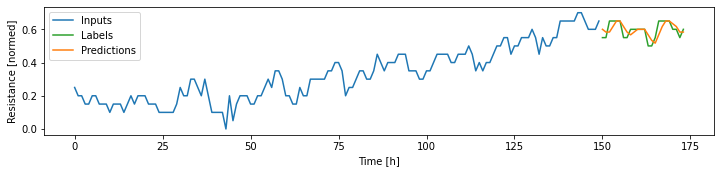

In [24]:
IPython.display.clear_output()

#multi_val_performance = model.evaluate(multi_window.val)
#multi_performance = model.evaluate(multi_window.test, verbose=0)
multi_window.plot(model)

In [25]:
test_df_test.shape()

TypeError: 'tuple' object is not callable

In [ ]:
pred = model.predict(test_df_test)